In [30]:
import pandas as pd
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm 


In [31]:
silver_import = pd.read_csv('silver prices.csv')
gold_import = pd.read_csv('gold prices.csv')

# Change domain to before massive geopolitical event of the pandemic which affected the economy on an unpredictable and massive scale.

pandemic_start_date = int(len(silver_import) * 0.36) # Brute forced this number looking for early march 2020 (beginning of pandemic)

silver = silver_import[pandemic_start_date:]
gold = gold_import[pandemic_start_date:]

start = "2013-08-19" 
end = pd.to_datetime(silver['Date'])[pandemic_start_date] # Standardize the date range for all data sets

treasury = yf.download("^TNX", start = start, end = end )
market = yf.download('^GSPC', start = start, end = end)
IEF = yf.download('IEF', start = start, end = end)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [32]:
market.rename(columns={'Close': 'Close/Last'}, inplace=True)
treasury.rename(columns={'Close': 'Close/Last'}, inplace=True)
IEF.rename(columns={'Close':'Close/Last'}, inplace=True)

28 observations have no value for "volume"
We need to fix this. We can use the average volume for the given year of missing observation to replace these values. 

In [33]:
treasury = treasury.reset_index()
IEF = IEF.reset_index()
market = market.reset_index()

In [34]:
gold['Date'] = pd.to_datetime(gold['Date'])
treasury['Date'] = pd.to_datetime(treasury['Date'])
silver['Date'] = pd.to_datetime(silver['Date'])


/var/folders/xn/bdvybb8s0477w33__fg2r6440000gn/T/ipykernel_78513/2325292776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold['Date'] = pd.to_datetime(gold['Date'])
/var/folders/xn/bdvybb8s0477w33__fg2r6440000gn/T/ipykernel_78513/2325292776.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  silver['Date'] = pd.to_datetime(silver['Date'])


In [35]:
gold['Year'] = gold['Date'].dt.year
gold_volume_mean = gold.groupby('Year')['Volume'].mean()

/var/folders/xn/bdvybb8s0477w33__fg2r6440000gn/T/ipykernel_78513/1625736910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold['Year'] = gold['Date'].dt.year


In [36]:
for year, mean_value in gold_volume_mean.items():
    gold.loc[(gold['Year'] == year) & (gold['Volume'].isna()), 'Volume'] = mean_value
gold = gold.drop('Year', axis=1)
gold.isna().sum()


Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

We have now fixed our missing values. Now, it makes sense for us to add the average price of a given day. We will also add in daily percent returns as well to measure percent change from day-to-day. 


In [37]:
gold['Daily Return'] = gold['Close/Last'].pct_change()
treasury['Daily Return'] = treasury['Close/Last'].pct_change()
market['Daily Return'] = market['Close/Last'].pct_change()
silver['Daily Return'] = silver['Close/Last'].pct_change()
IEF['Daily Return'] = IEF['Close/Last'].pct_change().dropna()


/var/folders/xn/bdvybb8s0477w33__fg2r6440000gn/T/ipykernel_78513/2745488055.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  silver['Daily Return'] = silver['Close/Last'].pct_change()


# Volatility Analysis
---
The **annualized volatility** ($ \sigma_{\text{annualized}}$) is calculated using the formula:

$$
\sigma_{\text{annualized}} = \sigma_{\text{daily}} \times \sqrt{252}
$$

where:

- $\sigma_{\text{daily}}$ is the stardard deviation of the stock's daily returns
- 252 is the typical number of trading days in a year.


In [40]:
def calculate_annualized_volatility(daily_returns):
    # calculate the daily standard deviation of returns
    daily_std = np.std(daily_returns)

    # convert daily standard deviation to annualized volatility
    # 252 trading days in a year
    annualized_volatility = daily_std * np.sqrt(252)

    return annualized_volatility

ann_vol_gold = calculate_annualized_volatility(gold['Daily Return']) 
ann_vol_silver = calculate_annualized_volatility(silver['Daily Return'])
ann_vol_treasury = calculate_annualized_volatility(treasury['Daily Return'])
ann_vol_mkt = calculate_annualized_volatility(market['Daily Return'])
ann_vol_IEF = calculate_annualized_volatility(IEF['Daily Return'])

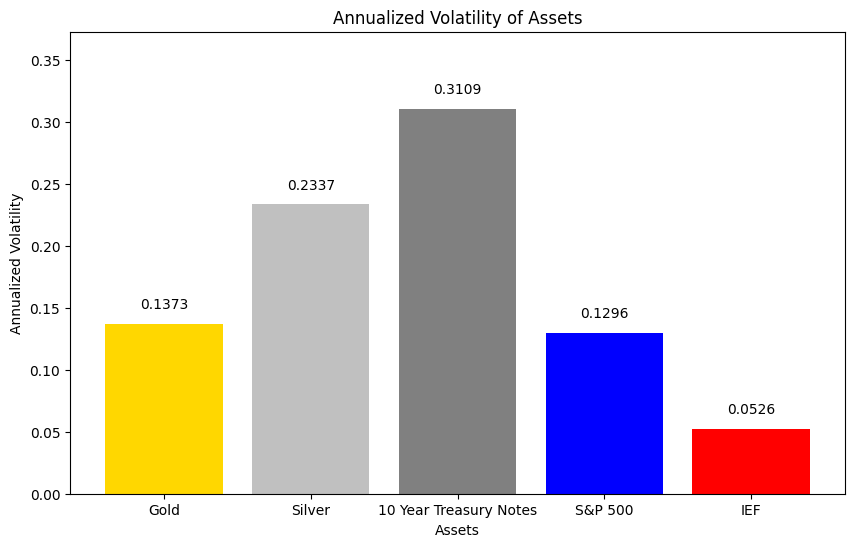

In [41]:
# Define the assets and their corresponding annualized volatilities
assets = ['Gold', 'Silver', '10 Year Treasury Notes', 'S&P 500','IEF']
annualized_volatilities = [ann_vol_gold, ann_vol_silver, ann_vol_treasury, ann_vol_mkt, ann_vol_IEF]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(assets, annualized_volatilities, color=['gold', 'silver', 'gray', 'blue','red'])
plt.title('Annualized Volatility of Assets')
plt.xlabel('Assets')
plt.ylabel('Annualized Volatility')
plt.ylim(0, max(annualized_volatilities) * 1.2)  # Adjust the y-axis limits if needed

# Add values on top of the bars
for i, v in enumerate(annualized_volatilities):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.show()


# Value at Risk (VaR)

In [43]:
def calculate_var(df, confidence_level=0.95, time_period=1):
    """
    Calculate Value at Risk (VaR) for a DataFrame of daily returns.

    Parameters:
    - gold: DataFrame with a 'Close/Last' column containing daily closing prices.
    - confidence_level: The desired confidence level (e.g., 0.95 for 95% confidence).
    - time_period: The time period for which to calculate VaR (e.g., 1 for 1-day VaR).

    Returns:
    - VaR: The VaR value at the specified confidence level for the given time period.
    """
    # Calculate daily returns as percentage change in the closing prices
    df['Daily Return'] = df['Close/Last'].pct_change()

    # Drop the NaN values that result from pct_change
    df = df.dropna()

    # Sort the returns to find the percentile
    sorted_returns = df['Daily Return'].sort_values()

    # Find the index corresponding to the VaR
    var_index = int((1 - confidence_level) * len(sorted_returns))

    # Find the VaR value at the specified confidence level
    VaR = sorted_returns.iloc[var_index]

    # If you want the VaR as a positive number (indicating a loss)
    VaR = abs(VaR)

    # Scale VaR for the specified time period
    scaled_VaR = VaR * np.sqrt(time_period)

    return scaled_VaR



/var/folders/xn/bdvybb8s0477w33__fg2r6440000gn/T/ipykernel_78513/1854828043.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Daily Return'] = df['Close/Last'].pct_change()


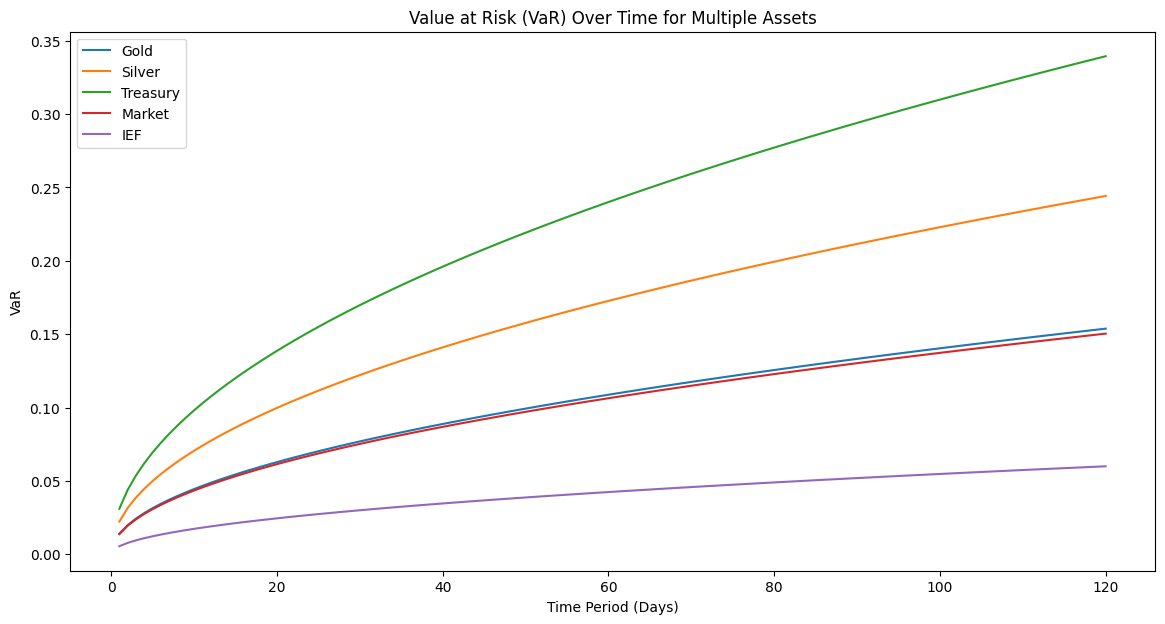

In [44]:
# Define a list of time periods for which to calculate VaR
time_periods = list(range(1, 121))  # 1 to 120 days

# Initialize empty dictionaries to store VaR values for each asset
var_values = { 'Gold': [], 'Silver': [], 'Treasury': [], 'Market': [], 'IEF':[] }

# Calculate VaR for each asset and time period
for asset_name, asset_df in [('Gold', gold), ('Silver', silver), ('Treasury', treasury), ('Market', market),('IEF',IEF)]:
    for time_period in time_periods:
        # Calculate VaR using your calculate_var function or any other method
        var = calculate_var(asset_df, 0.95, time_period)
        var_values[asset_name].append(var)

# Create a DataFrame to store the results
var_df = pd.DataFrame({'Time Period': time_periods})

# Add VaR values for each asset to the DataFrame
for asset_name in var_values.keys():
    var_df[asset_name] = var_values[asset_name]

# Plot VaR over time as a line chart for all assets
plt.figure(figsize=(14, 7))

for asset_name in var_values.keys():
    plt.plot(var_df['Time Period'], var_df[asset_name], linestyle='-', label=asset_name)

plt.title('Value at Risk (VaR) Over Time for Multiple Assets')
plt.xlabel('Time Period (Days)')
plt.ylabel('VaR')
plt.legend()
plt.grid(False)
plt.show()

In [45]:
def calculate_cumulative_returns(daily_returns):
    cumulative_returns = (1 + daily_returns).cumprod() - 1
    return cumulative_returns

In [46]:
# Calculate cumulative returns for each commodity
cumulative_returns_gold = calculate_cumulative_returns(gold['Daily Return'])
cumulative_returns_silver = calculate_cumulative_returns(silver['Daily Return'])
cumulative_returns_treasury = calculate_cumulative_returns(treasury['Daily Return'])
cumulative_returns_market = calculate_cumulative_returns(market['Daily Return'])

start_date = '2013-08-17'  # Replace with the actual start date
end_date = '2023-08-18'    # Replace with the actual end date
date_range = pd.date_range(start=start_date, end=end_date)

# Create a DataFrame to store the cumulative returns with the date range as the index
cumulative_returns_df = pd.DataFrame({
    'Gold': cumulative_returns_gold,
    'Silver': cumulative_returns_silver,
    'Treasury': cumulative_returns_treasury,
    'Market': cumulative_returns_market
}, index=gold['Date'])



## Sharpe and Sortino Ratio ##

---

### Sharpe Ratio ##

The Sharpe Ratio measures how much excess return received for the extra volatility endured for holding a riskier asset.

The Sharpe Ratio is calculated using the formula:

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

where:
- $ R_p $ is the average return of the portfolio (or stock).
- $ R_f $ is the risk-free rate.
- $ \sigma_p $ is the standard deviation of the portfolio’s excess returns.

A higher Sharpe Ratio is better. A negative Sharpe Ratio indicates that the investment's return is less than the risk-free rate.

### Sortino Ratio ###

Similar to the Sharpe Ratio, the Sortino Ratio also measures risk-adjusted return, but only penalizes negative volatility (downside risk). This ratio designed to focus only on the downside risk of an investment.

The Sortino Ratio is calculated using the formula:

$$
\text{Sortino Ratio} = \frac{R_p - R_f}{\sigma_d}
$$

where:
- $ R_p $ is the average return of the portfolio (or stock).
- $ R_f $ is the risk-free rate.
- $ \sigma_d $ is the downside deviation (standard deviation of negative asset returns).


A higher Sortino Ratio indicates a more favorable risk-adjusted return when considering only downside risk.

In [47]:
def calculate_sharpe_ratio(daily_returns, risk_free_rate):
    """
    Calculate the Sharpe Ratio.
    
    Parameters:
    - returns: A pandas Series or DataFrame of investment returns.
    - risk_free_rate: The risk-free rate, typically annualized, e.g., 0.03 for 3%.

    Returns:
    - Sharpe Ratio as a float.
    """
    excess_returns = daily_returns - risk_free_rate
    mean_excess_return = excess_returns.mean()
    std_deviation = excess_returns.std()
    
    sharpe_ratio = mean_excess_return / std_deviation if std_deviation != 0 else np.nan
    
    return sharpe_ratio

def calculate_sortino_ratio(daily_returns, risk_free_rate, target_return=0):
    """
    Calculate the Sortino Ratio.

    Parameters:
    - returns: A pandas Series or DataFrame of investment returns.
    - risk_free_rate: The risk-free rate, typically annualized, e.g., 0.03 for 3%.
    - target_return: The target return for calculating downside deviation.

    Returns:
    - Sortino Ratio as a float.
    """
    excess_returns = daily_returns - risk_free_rate
    downside_returns = np.minimum(excess_returns, target_return)
    downside_deviation = downside_returns.std()
    
    sortino_ratio = (excess_returns.mean() - target_return) / downside_deviation if downside_deviation != 0 else np.nan
    
    return sortino_ratio




In [48]:
annual_risk_free_rate = 0.0524  # 5.24%
risk_free_rate = (1 + annual_risk_free_rate)**(1/252) - 1

In [49]:
sharpe_ratios = {}
sortino_ratios = {}

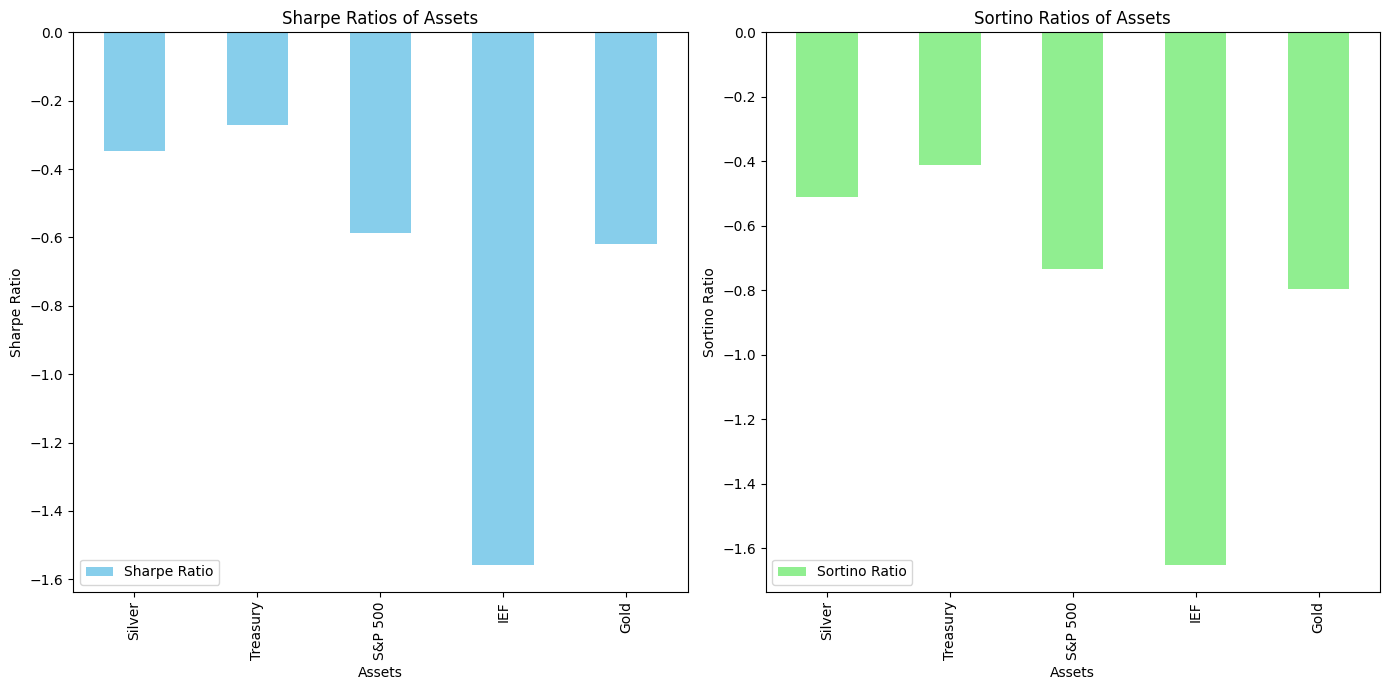

In [50]:
for column in combined_returns.columns:
    sharpe_ratios[column] = calculate_sharpe_ratio(combined_returns[column], .00524)
    sortino_ratios[column] = calculate_sortino_ratio(combined_returns[column], .00524)

# Convert the Sharpe and Sortino ratios into DataFrames for easy plotting
sharpe_df = pd.DataFrame(list(sharpe_ratios.items()), columns=['Asset', 'Sharpe Ratio'])
sortino_df = pd.DataFrame(list(sortino_ratios.items()), columns=['Asset', 'Sortino Ratio'])

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Sharpe Ratio Plot
sharpe_df.plot(kind='bar', x='Asset', y='Sharpe Ratio', ax=ax[0], color='skyblue')
ax[0].set_title('Sharpe Ratios of Assets')
ax[0].set_ylabel('Sharpe Ratio')
ax[0].set_xlabel('Assets')

# Sortino Ratio Plot
sortino_df.plot(kind='bar', x='Asset', y='Sortino Ratio', ax=ax[1], color='lightgreen')
ax[1].set_title('Sortino Ratios of Assets')
ax[1].set_ylabel('Sortino Ratio')
ax[1].set_xlabel('Assets')

plt.tight_layout()
plt.show()


# Monte Carlo Simulation for Portfolio Optimization

In [51]:
num_portfolios = 10000  # 10000 simulations
all_weights = np.zeros((num_portfolios, len(combined_returns.columns)))
return_arr = np.zeros(num_portfolios)
volatility_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

for i in range(num_portfolios):
    # create random weight vector
    weights = np.array(np.random.random(len(combined_returns.columns)))
    weights = weights / np.sum(weights)

    # save weights
    all_weights[i, :] = weights

    # expected return
    return_arr[i] = np.sum((combined_returns.mean() * weights * 252))

    # expected volatility
    volatility_arr[i] = np.sqrt(np.dot(weights.T, np.dot(combined_returns.cov() * 252, weights)))

    # sharpe ratio
    sharpe_arr[i] = return_arr[i] / volatility_arr[i]

max_sharpe_ratio = sharpe_arr.max()
max_sharpe_idx = sharpe_arr.argmax()
max_sharpe_weights = all_weights[max_sharpe_idx, :]


In [52]:
print(f"Maximum Sharpe Ratio: {max_sharpe_ratio:.2f}")


Maximum Sharpe Ratio: 1.12


In [53]:
print("Weights of the Best Portfolio:")
for stock, weight in zip(combined_returns.columns, max_sharpe_weights):
    print(f"{stock}: {weight:.2%}")

Weights of the Best Portfolio:
Silver: 6.57%
Treasury: 1.49%
S&P 500: 44.32%
IEF: 46.77%
Gold: 0.85%


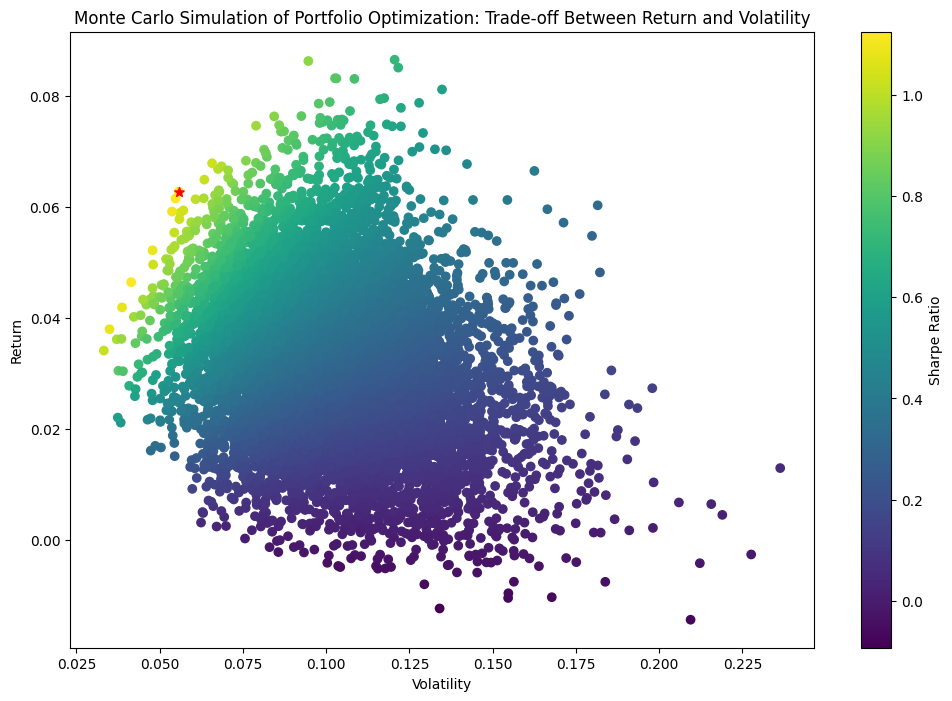

In [54]:
plt.figure(figsize=(12,8))
plt.scatter(volatility_arr, return_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Monte Carlo Simulation of Portfolio Optimization: Trade-off Between Return and Volatility')

# Mark the point with the highest Sharpe ratio
plt.scatter(volatility_arr[max_sharpe_idx], return_arr[max_sharpe_idx], c='red', s=50, marker='*', label='Maximum Sharpe Ratio')